In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 加载和预处理数据
data_path = '/Users/luolan/Desktop/S&P500_data.csv'
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

data.index = pd.to_datetime(data.index)
data = data.asfreq('B')
data = data.fillna(method='ffill').fillna(method='bfill')

data['Close_Smoothed'] = data['Close'].rolling(window=5).mean().fillna(method='bfill')
data = data.dropna()

# ADF检验函数
def adf_test(series):
    result = adfuller(series.dropna())  # 确保数据不包含NaN值
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
        
# 对平滑后的收盘价进行ADF检验
print("ADF Test for Close_Smoothed:")
adf_test(data['Close_Smoothed'])

ADF Test for Close_Smoothed:
ADF Statistic: 0.5945517509243636
p-value: 0.987480566505495
Critical Values: {'1%': -3.432886154825581, '5%': -2.862660475187928, '10%': -2.5673664697163323}
The series is not stationary.


ADF Test for Differenced Close_Smoothed:
ADF Statistic: -10.026891837536995
p-value: 1.6231169827228732e-17
Critical Values: {'1%': -3.432886154825581, '5%': -2.862660475187928, '10%': -2.5673664697163323}
The series is stationary.


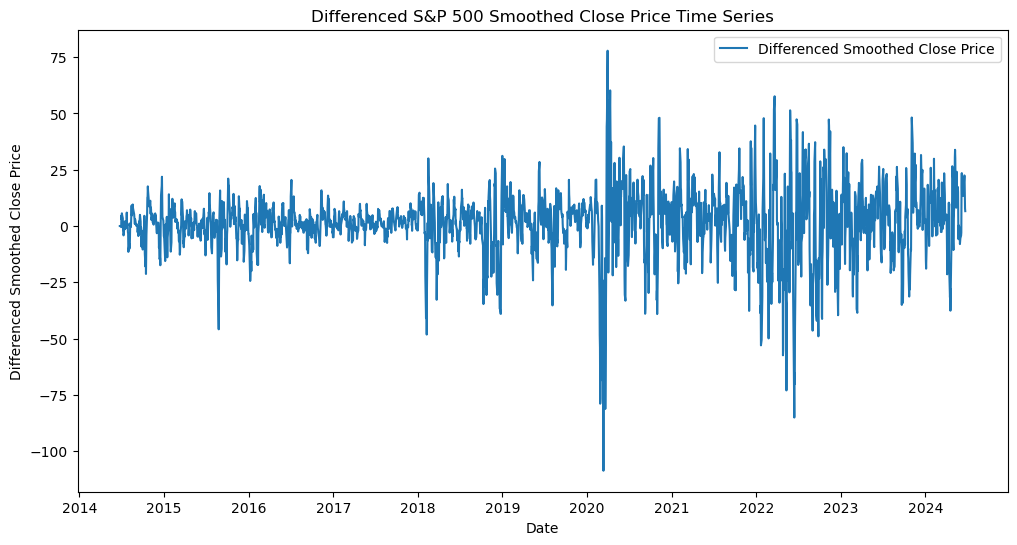

In [3]:
# 对平滑后的收盘价进行一次差分
data['Close_Smoothed_diff'] = data['Close_Smoothed'].diff().dropna()
print("ADF Test for Differenced Close_Smoothed:")
adf_test(data['Close_Smoothed_diff'])

# 绘制差分后的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(data['Close_Smoothed_diff'].index, data['Close_Smoothed_diff'], label='Differenced Smoothed Close Price')
plt.title('Differenced S&P 500 Smoothed Close Price Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Smoothed Close Price')
plt.legend()
plt.show()

In [4]:
# 拆分数据集
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# 使用auto_arima选择最佳模型
model = auto_arima(train_data['Close_Smoothed_diff'].dropna(), 
                   start_p=1, start_q=1, max_p=5, max_q=5, 
                   d=1, seasonal=False, trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15221.748, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15232.935, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15226.568, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15226.855, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15230.936, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15230.036, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15229.786, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15227.836, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15228.040, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15219.749, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15224.855, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15224.568, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15228.037, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]  

In [5]:
# 在训练集上进行预测
y_train_pred = model.predict_in_sample()

# 为了计算误差，我们需要确保 y_train_pred 和 train_data['Close_Smoothed_diff'] 的长度匹配
train_data = train_data.iloc[1:]  # 去掉第一个 NaN
y_train_pred = y_train_pred[:len(train_data)]  # 确保预测长度一致

# 计算训练集上的评估指标
mse_train_arima = mean_squared_error(train_data['Close_Smoothed_diff'], y_train_pred)
rmse_train_arima = np.sqrt(mse_train_arima)
mae_train_arima = mean_absolute_error(train_data['Close_Smoothed_diff'], y_train_pred)
r2_train_arima = r2_score(train_data['Close_Smoothed_diff'], y_train_pred)

print(f'Training Set Metrics (ARIMA):')
print(f'MSE: {mse_train_arima}')
print(f'RMSE: {rmse_train_arima}')
print(f'MAE: {mae_train_arima}')
print(f'R²: {r2_train_arima}')

# 在测试集上进行预测
y_test_pred_diff = model.predict(n_periods=len(test_data))

# 还原差分后的预测结果
last_train_value = train_data['Close_Smoothed'].iloc[-1]
y_test_pred = last_train_value + np.cumsum(y_test_pred_diff)

# 计算测试集上的评估指标
mse_test_arima = mean_squared_error(test_data['Close_Smoothed'], y_test_pred)
rmse_test_arima = np.sqrt(mse_test_arima)
mae_test_arima = mean_absolute_error(test_data['Close_Smoothed'], y_test_pred)
r2_test_arima = r2_score(test_data['Close_Smoothed'], y_test_pred)

print(f'Test Set Metrics (ARIMA):')
print(f'MSE: {mse_test_arima}')
print(f'RMSE: {rmse_test_arima}')
print(f'MAE: {mae_test_arima}')
print(f'R²: {r2_test_arima}')

Training Set Metrics (ARIMA):
MSE: 86.0476274217694
RMSE: 9.276186038548893
MAE: 5.900214184462676
R²: 0.558847066311094
Test Set Metrics (ARIMA):
MSE: 5783939.426872646
RMSE: 2404.98220926323
MAE: 2054.5109902456757
R²: -24.50402606134815


In [6]:
# 保存预测结果到CSV文件
train_results = pd.DataFrame({
    'Actual': train_data['Close_Smoothed'],
    'Prediction': y_train_pred
})
train_results.to_csv('modelARIMA_train_predictions.csv', index=False)

test_results = pd.DataFrame({
    'Actual': test_data['Close_Smoothed'],
    'Prediction': y_test_pred
})
test_results.to_csv('modelARIMA_test_predictions.csv', index=False)

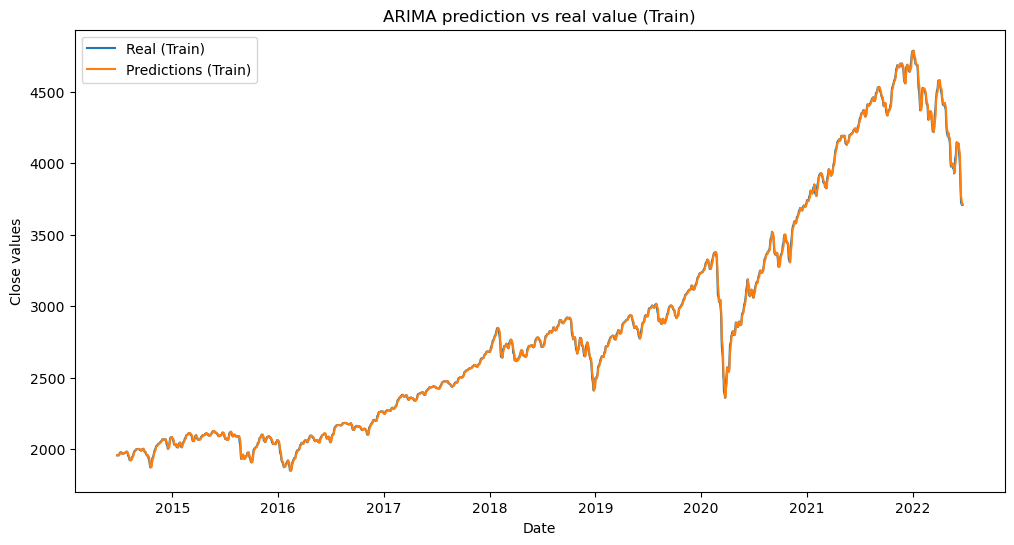

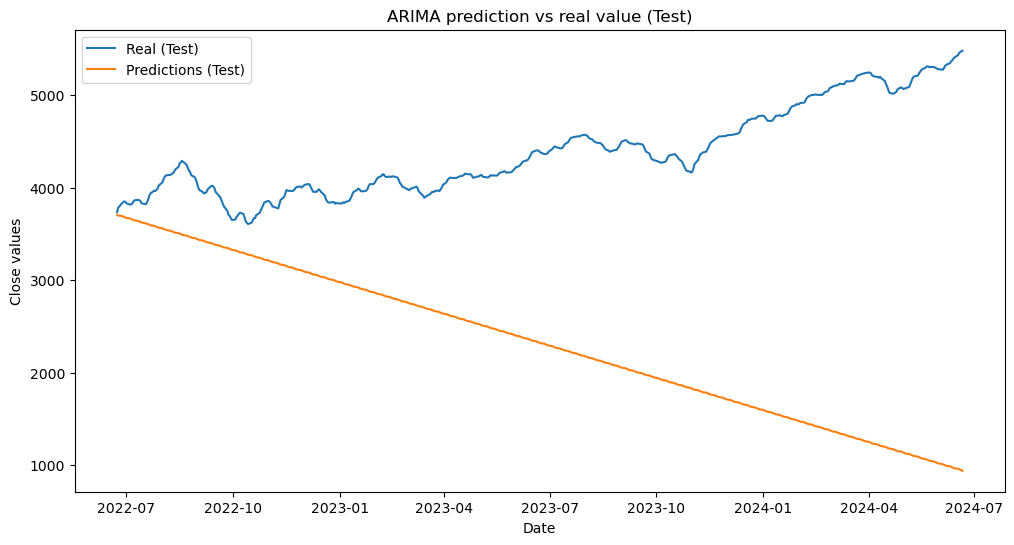

In [7]:
# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close_Smoothed'], label='Real (Train)')
plt.plot(train_data.index, y_train_pred.cumsum() + train_data['Close_Smoothed'].iloc[0], label='Predictions (Train)')
plt.title('ARIMA prediction vs real value (Train)')
plt.xlabel('Date')
plt.ylabel('Close values')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close_Smoothed'], label='Real (Test)')
plt.plot(test_data.index, y_test_pred, label='Predictions (Test)')
plt.title('ARIMA prediction vs real value (Test)')
plt.xlabel('Date')
plt.ylabel('Close values')
plt.legend()
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 读取逆标准化后的预测结果
test_results = pd.read_csv('modelARIMA_test_predictions.csv')

# 定义短期预测窗口（例如，10天）
short_term_window = 10

# 提取短期预测和实际值
short_term_actual = test_results['Actual'][:short_term_window]
short_term_predicted = test_results['Prediction'][:short_term_window]

# 计算短期预测的误差指标
mse_short_term = mean_squared_error(short_term_actual, short_term_predicted)
rmse_short_term = np.sqrt(mse_short_term)
mae_short_term = mean_absolute_error(short_term_actual, short_term_predicted)

print("短期预测的误差指标：")
print(f'MSE: {mse_short_term}')
print(f'RMSE: {rmse_short_term}')
print(f'MAE: {mae_short_term}')

# 计算短期预测的准确率（定义误差范围为±5%）
error_margin = 0.05  # 误差范围±5%
accurate_predictions = np.sum(np.abs(short_term_actual - short_term_predicted) <= error_margin * short_term_actual)
accuracy = accurate_predictions / len(short_term_actual)

print("短期预测的准确率：", accuracy)


短期预测的误差指标：
MSE: 20552.028719474354
RMSE: 143.35978766542016
MAE: 136.81170889805207
短期预测的准确率： 1.0


In [9]:
# 定义长期预测窗口（例如，30天）
long_term_window = 365

# 提取长期预测和实际值
long_term_actual = test_results['Actual'][:long_term_window]
long_term_predicted = test_results['Prediction'][:long_term_window]

# 计算长期预测的误差指标
mse_long_term = mean_squared_error(long_term_actual, long_term_predicted)
rmse_long_term = np.sqrt(mse_long_term)
mae_long_term = mean_absolute_error(long_term_actual, long_term_predicted)

print("长期预测的误差指标：")
print(f'MSE: {mse_long_term}')
print(f'RMSE: {rmse_long_term}')
print(f'MAE: {mae_long_term}')

# 计算长期预测的准确率（定义误差范围为±5%）
error_margin = 0.05  # 误差范围±5%
accurate_predictions_long_term = np.sum(np.abs(long_term_actual - long_term_predicted) <= error_margin * long_term_actual)
accuracy_long_term = accurate_predictions_long_term / len(long_term_actual)

print("长期预测的准确率：", accuracy_long_term)

长期预测的误差指标：
MSE: 2456696.3083619894
RMSE: 1567.3851818752114
MAE: 1370.9862379877097
长期预测的准确率： 0.0273972602739726


## 模拟交易

Final portfolio value: $13486.00
Maximum Drawdown: $1363.61
Sharpe Ratio: 2.86
Win Rate: 0.00%
Total Trades: 1
Annualized Return: 15.53%


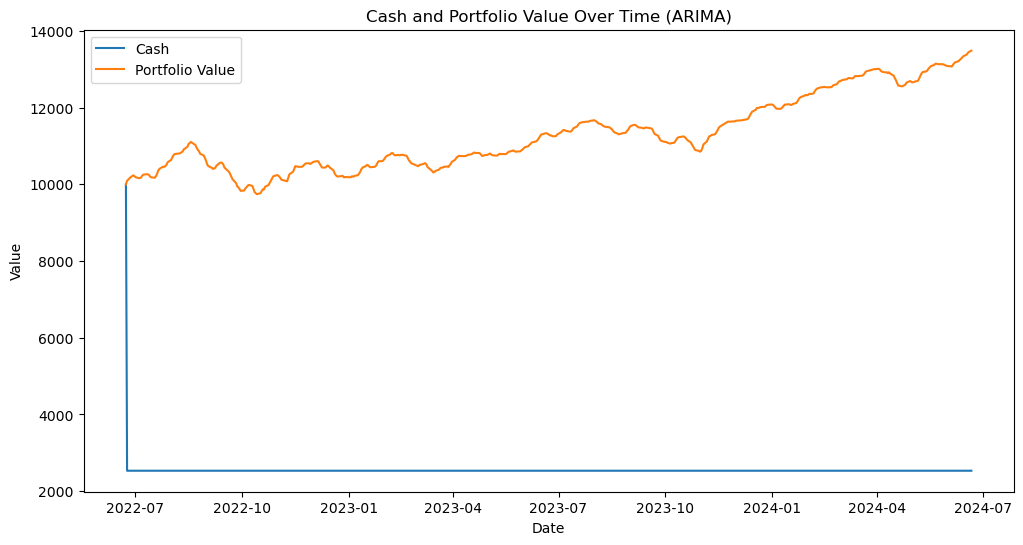

In [10]:
# 交易策略部分（基于逆差分后的预测结果）
initial_cash = 10000  # 初始现金
shares = 0  # 初始持有的股票数量
cash_history = [initial_cash]  # 用于记录每个时间点的现金
portfolio_value_history = []  # 用于记录每个时间点的资产总值（现金 + 持有的股票价值）

# 交易统计
trades = 0  # 交易次数
profits = []  # 每次交易的利润
previous_price = 0

# 交易模拟（假设在预测值大于实际值时卖出，小于实际值时买入）
for i in range(len(y_test_pred)):
    current_price = test_data['Close_Smoothed'].iloc[i]
    predicted_price = y_test_pred[i]
    
    # 卖出条件
    if predicted_price > current_price and shares > 0:
        trades += 1
        initial_cash += shares * current_price
        if previous_price != 0:
            profits.append(shares * (current_price - previous_price))
        shares = 0
    
    # 买入条件
    elif predicted_price < current_price and initial_cash >= current_price:
        trades += 1
        shares_to_buy = initial_cash // current_price
        previous_price = current_price
        initial_cash -= shares_to_buy * current_price
        shares += shares_to_buy
    
    # 记录当前现金和总资产值
    cash_history.append(initial_cash)
    portfolio_value = initial_cash + shares * current_price
    portfolio_value_history.append(portfolio_value)

# 修正长度以匹配test_index
cash_history = cash_history[:-1]

# 计算最终的资产值
final_value = initial_cash + shares * test_data['Close_Smoothed'].iloc[-1]
print(f'Final portfolio value: ${final_value:.2f}')

# 计算最大回撤
drawdown = [max(portfolio_value_history[:i+1]) - portfolio_value_history[i] for i in range(len(portfolio_value_history))]
max_drawdown = max(drawdown)
print(f'Maximum Drawdown: ${max_drawdown:.2f}')

# 计算夏普比率
returns = np.diff(portfolio_value_history) / portfolio_value_history[:-1]
annualized_return = np.mean(returns) * 252
annualized_volatility = np.std(returns) * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# 计算胜率
win_rate = sum([1 for profit in profits if profit > 0]) / len(profits) if profits else 0
print(f'Win Rate: {win_rate:.2%}')

# 计算交易次数
print(f'Total Trades: {trades}')

# 计算年化收益率
days = len(test_data)
annualized_return_percentage = ((final_value / 10000) ** (252 / days) - 1) * 100
print(f'Annualized Return: {annualized_return_percentage:.2f}%')

# 绘制现金和资产总值的变化情况
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:len(cash_history)], cash_history, label='Cash')
plt.plot(test_data.index[:len(portfolio_value_history)], portfolio_value_history, label='Portfolio Value')
plt.title('Cash and Portfolio Value Over Time (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()